In [1]:
import os
import numpy as np
import random
import scipy.sparse as sparse
from scipy.sparse import *
from sklearn.utils import shuffle
import pandas as pd
from math import ceil
from tqdm import trange
from sklearn.metrics import *
import sys
import pickle
from itertools import islice

In [2]:
file_dir = '/Users/payoj/Documents/Spring 2019/Recommender Systems/data/Ciao/'
pos_file = open(file_dir+"/positive_feedback_dataframe.pkl",'rb')
soc_file = open(file_dir+"/social_positive_feedback_dataframe.pkl",'rb')
P = positive_df = pickle.load(pos_file)
unique_items = len(P['item'].unique())
SP = social_positive_df = pickle.load(soc_file)
print('data dimension: \n', positive_df.shape)

data dimension: 
 (34130, 3)


In [3]:
def create_matrix(data):
    for col in ('item', 'user', 'rating'):
        data[col] = data[col].astype('category')
    
    code_user = dict(zip(data['user'].cat.codes, data['user']))
    user_code = dict(zip(data['user'], data['user'].cat.codes))
    code_item = dict(zip(data['item'].cat.codes, data['item']))
    item_code = dict(zip(data['item'], data['item'].cat.codes))
    
    mappings = {'code_user' : code_user, 'user_code' : user_code, 'code_item' : code_item, 'item_code' : item_code}

    ratings = csr_matrix((data['rating'], (data['user'].cat.codes, data['item'].cat.codes)))
    ratings.eliminate_zeros()
    return ratings, data, mappings

In [4]:
X, df, mappings = create_matrix(positive_df)

In [5]:
def create_train_test(ratings, test_size = 0.2, seed = 1234):
    assert test_size < 1.0 and test_size > 0.0

    # Dictionary Of Keys based sparse matrix is more efficient
    # for constructing sparse matrices incrementally compared with csr_matrix
    train = ratings.copy().todok()
    test = dok_matrix(train.shape)
    
    # for all the users assign randomly chosen interactions
    # to the test and assign those interactions to zero in the training;
    # when computing the interactions to go into the test set, 
    # remember to round up the numbers (e.g. a user has 4 ratings, if the
    # test_size is 0.2, then 0.8 ratings will go to test, thus we need to
    # round up to ensure the test set gets at least 1 rating)
    rstate = np.random.RandomState(seed)
    for u in range(ratings.shape[0]):
        split_index = ratings[u].indices
        n_splits = ceil(test_size * split_index.shape[0])
        test_index = rstate.choice(split_index, size = n_splits, replace = False)
        test[u, test_index] = ratings[u, test_index]
        train[u, test_index] = 0
    
    train, test = train.tocsr(), test.tocsr()
    return train, test

In [6]:
X_train, X_test = create_train_test(X, test_size = 0.1, seed = 20191004)
X_train

<2104x10768 sparse matrix of type '<class 'numpy.int64'>'
	with 29673 stored elements in Compressed Sparse Row format>

In [7]:
class Sample:
    def __init__(self, P, SP):
        self.P = P
        self.SP = SP
        
    def static(self, social = False):
        user = np.random.choice(self.P['user'])
        
        items = {}
        
        items['P'] = np.random.choice(self.P.query('user == @user')['item'])
        tot_items = set(self.P['item'])
        if social:
            df_sp = list(self.SP.query('user == @user')['item'])
            if(len(df_sp)):
                items['SP'] = np.random.choice(df_sp)

        
        pos_items = []
        for key in items:
            pos_items.append(items[key])
        
        neg_items = list(tot_items - set(pos_items))
                
        items['N'] = np.random.choice(neg_items)
        
        return user, items

In [8]:
def get_mappings(code, key):
    return code[key]

In [88]:
def auc_score(model, ratings):
    """
    computes area under the ROC curve (AUC).
    The full name should probably be mean
    auc score as it is computing the auc
    for every user's prediction and actual
    interaction and taking the average for
    all users
    
    Parameters
    ----------
    model : BPR instance
        Trained BPR model
        
    ratings : scipy sparse csr_matrix, shape [n_users, n_items]
        sparse matrix of user-item interactions
    
    Returns
    -------
    auc : float 0.0 ~ 1.0
    """
    auc = 0.0
    
    n_users, n_items = ratings.shape
    for user, row in enumerate(ratings):
        y_pred = model._predict_user(user)
        y_true = np.zeros(n_items)
        y_true[row.indices] = 1
        auc += roc_auc_score(y_true, y_pred)
    auc /= n_users
    return auc

In [79]:
def create_train_test(ratings, test_size = 0.2, seed = 1234):
    """
    split the user-item interactions matrix into train and test set
    by removing some of the interactions from every user and pretend
    that we never seen them
    
    Parameters
    ----------
    ratings : scipy sparse csr_matrix, shape [n_users, n_items]
        The user-item interactions matrix
    
    test_size : float between 0.0 and 1.0, default 0.2
        Proportion of the user-item interactions for each user
        in the dataset to move to the test set; e.g. if set to 0.2
        and a user has 10 interactions, then 2 will be moved to the
        test set
    
    seed : int, default 1234
        Seed for reproducible random splitting the 
        data into train/test set
    
    Returns
    ------- 
    train : scipy sparse csr_matrix, shape [n_users, n_items]
        Training set
    
    test : scipy sparse csr_matrix, shape [n_users, n_items]
        Test set
    """
    assert test_size < 1.0 and test_size > 0.0

    # Dictionary Of Keys based sparse matrix is more efficient
    # for constructing sparse matrices incrementally compared with csr_matrix
    train = ratings.copy().tocsr()
    test = csr_matrix(train.shape)
    
    # for all the users assign randomly chosen interactions
    # to the test and assign those interactions to zero in the training;
    # when computing the interactions to go into the test set, 
    # remember to round up the numbers (e.g. a user has 4 ratings, if the
    # test_size is 0.2, then 0.8 ratings will go to test, thus we need to
    # round up to ensure the test set gets at least 1 rating)
    rstate = np.random.RandomState(seed)
    for u in range(ratings.shape[0]):
        split_index = ratings[u].indices
        n_splits = ceil(test_size * split_index.shape[0])
        test_index = rstate.choice(split_index, size = n_splits, replace = False)
        test[u, test_index] = ratings[u, test_index]
        train[u, test_index] = 0
    
    train, test = train.tocsr(), test.tocsr()
    return train, test

In [70]:
X_train, X_test = create_train_test(X, test_size = 0.1, seed = 20191004)
X_train

/anaconda3/lib/python3.7/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


<2104x10768 sparse matrix of type '<class 'numpy.int64'>'
	with 33944 stored elements in Compressed Sparse Row format>

In [71]:
print (X_test.shape)
print (X_test.getnnz())

(2104, 10768)
4271


In [72]:
print (X_train.shape)
print (X_train.getnnz())

(2104, 10768)
33944


In [89]:
class SBPR2:
    """
    Bayesian Personalized Ranking (BPR) for implicit feedback data

    Parameters
    ----------
    learning_rate : float, default 0.01
        learning rate for gradient descent

    n_factors : int, default 20
        Number/dimension of user and item latent factors

    n_iters : int, default 15
        Number of iterations to train the algorithm
        
    batch_size : int, default 1000
        batch size for batch gradient descent, the original paper
        uses stochastic gradient descent (i.e., batch size of 1),
        but this can make the training unstable (very sensitive to
        learning rate)

    reg : int, default 0.01
        Regularization term for the user and item latent factors

    seed : int, default 1234
        Seed for the randomly initialized user, item latent factors

    verbose : bool, default True
        Whether to print progress bar while training

    Attributes
    ----------
    user_factors : 2d ndarray, shape [n_users, n_factors]
        User latent factors learnt

    item_factors : 2d ndarray, shape [n_items, n_factors]
        Item latent factors learnt

    References
    ----------
    S. Rendle, C. Freudenthaler, Z. Gantner, L. Schmidt-Thieme 
    Bayesian Personalized Ranking from Implicit Feedback
    - https://arxiv.org/abs/1205.2618
    """
    def __init__(self, unique_items = 100, learning_rate = 0.01, n_factors = 15, n_iters = 10, batch_size = 1, 
                 social_coefficient = 1, reg_u = 0.015, reg_i = 0.025, reg_k = 0.025, reg_j = 0.025, seed = 1234, verbose = True):
        self.unique_items = unique_items
        self.reg_u = reg_u
        self.reg_i = reg_i
        self.reg_k = reg_k
        self.reg_j = reg_j
        self.s_uk = social_coefficient
        
        self.seed = seed
        self.verbose = verbose
        self.n_iters = n_iters
        self.n_factors = n_factors
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        
        # to avoid re-computation at predict
        self._prediction = None
        
    def fit(self, ratings, sampler):
        """
        Parameters
        ----------
        ratings : scipy sparse csr_matrix, shape [n_users, n_items]
            sparse matrix of user-item interactions
        """
        n_users, n_items = ratings.shape
        batch_size = self.batch_size
        if n_users < batch_size:
            batch_size = n_users
            sys.stderr.write('WARNING: Batch size is greater than number of users,'
                             'switching to a batch size of {}\n'.format(n_users))

        batch_iters = n_users // batch_size
        
        # initialize random weights
        rstate = np.random.RandomState(self.seed)
        self.user_factors = rstate.normal(size = (n_users, self.n_factors))
        self.item_factors = rstate.normal(size = (n_items, self.n_factors))
        
        # progress bar for training iteration if verbose is turned on
        loop = range(self.n_iters)
        if self.verbose:
            loop = trange(self.n_iters, desc = self.__class__.__name__)
        self.auc_scores = []
        for _ in loop:
            for _ in range(batch_iters):
                user, items = sampler.static(True)
                sampled_users = np.zeros(self.batch_size, dtype = np.int)
                sampled_users[0] = get_mappings(mappings['user_code'], user)
                
                sampled_pos_items = np.zeros(self.batch_size, dtype = np.int)
                sampled_pos_items[0] = get_mappings(mappings['item_code'], items['P'])
                
                
                sampled_soc_pos_items = np.zeros(self.batch_size, dtype = np.int)
                if 'SP' in items:
                    sampled_soc_pos_items[0] = get_mappings(mappings['item_code'], items['SP'])
                else:
                    sampled_soc_pos_items[0] = -1
                
                
                sampled_neg_items = np.zeros(self.batch_size, dtype = np.int)
                sampled_neg_items[0] = get_mappings(mappings['item_code'], items['N'])
                
                self._update(sampled_users, sampled_pos_items, sampled_soc_pos_items, sampled_neg_items)
            self.auc_scores.append(auc_score(sbpr2, X_test))
            print(self.auc_scores[-1])
        return self
    
    
    def _update(self, u, i, k ,j):
        """
        update according to the bootstrapped user u, 
        positive item i and negative item j
        """
        user_u = self.user_factors[u]
        item_i = self.item_factors[i]
        item_j = self.item_factors[j]
        if k != -1:
            item_k = self.item_factors[k]
        else:
            item_k = 0
        
        # decompose the estimator, compute the difference between
        # the score of the (positive and social items) and (social and negative items) ; 

        r_ukj = np.sum(user_u * (item_k - item_j), axis = 1)
        sigmoid_ukj = np.exp(-r_ukj) / (1.0 + np.exp(-r_ukj))     # derivation of 1/(1+exp(-x))
        
        r_uik = np.sum(user_u*(item_i - item_k), axis = 1)/(1 + self.s_uk)
        sigmoid_uik = np.exp(-r_uik) / (1.0 + np.exp(-r_uik))     # derivation of 1/(1+exp(-x))
        
        # repeat the 1 dimension sigmoid n_factors times so
        # the dimension will match when doing the update
        
        sigmoid_uik_tiled = np.tile(sigmoid_uik, (self.n_factors, 1)).T
        sigmoid_ukj_tiled = np.tile(sigmoid_ukj, (self.n_factors, 1)).T
        

        # update using gradient descent

        grad_u = sigmoid_uik_tiled * ((item_k - item_i)/(1 + self.s_uk)) + sigmoid_ukj_tiled * (item_j - item_k) + self.reg_u * user_u
        grad_i = sigmoid_uik_tiled * (-user_u)/(1 + self.s_uk) + self.reg_i * item_i
        grad_k = sigmoid_uik_tiled * (user_u/(1 + self.s_uk)) + (sigmoid_ukj_tiled * -user_u) + self.reg_k * item_k
        grad_j = (sigmoid_ukj_tiled * user_u) + self.reg_j * item_j
        
        self.user_factors[u] -= self.learning_rate * grad_u
        self.item_factors[i] -= self.learning_rate * grad_i
        self.item_factors[k] -= self.learning_rate * grad_k
        self.item_factors[j] -= self.learning_rate * grad_j
        
        return self

    def predict(self):
        """
        Obtain the predicted ratings for every users and items
        by doing a dot product of the learnt user and item vectors.
        The result will be cached to avoid re-computing it every time
        we call predict, thus there will only be an overhead the first
        time we call it. Note, ideally you probably don't need to compute
        this as it returns a dense matrix and may take up huge amounts of
        memory for large datasets
        """
        if self._prediction is None:
            self._prediction = self.user_factors.dot(self.item_factors.T) 
            self._prediction = (self._prediction-min(self._prediction))*5/(max(self._prediction) - min(self._prediction)) # delete if not performing well
        return self._prediction

    def _predict_user(self, user):
        """
        returns the predicted ratings for the specified user,
        this is mainly used in computing evaluation metric
        """
        user_pred = self.user_factors[user].dot(self.item_factors.T)
        user_pred = (user_pred-min(user_pred))*5/(max(user_pred) - min(user_pred)) # delete if not performing well
        
        return user_pred
    
    def recommend(self, data, N = 5):
        """
        Returns the top N ranked items for given user id,
        excluding the ones that the user already liked
        
        Parameters
        ----------
        ratings : scipy sparse csr_matrix, shape [n_users, n_items]
            sparse matrix of user-item interactions 
        
        N : int, default 5
            top-N similar items' N
        
        Returns
        -------
        recommendation : 2d ndarray, shape [number of users, N]
            each row is the top-N ranked item for each query user
        """
        n_users = data.shape[0]
        recommendation = np.zeros((n_users, N))
        scores = np.zeros((n_users, N))
        users = []
        ranks = []
        for user in range(n_users):
            users.append([user]*N)
            ranks.append([i for i in range(1,N+1)])
            topN_items, topN_scores = self.recommend_user(data, user, N)
            recommendation[user], scores[user] = topN_items, topN_scores

        return recommendation, scores, users, ranks
    
    def get_item_ratings(self, data, u):
        
        if u not in self.item_ratings:
            items = data[u].indices
            ratings = data[u].data
            
            self.item_ratings[u] = []
            for i in range(len(items)):
                self.item_ratings[u].append((items[i], ratings[i]))
                
        return self.item_ratings[u]
        

    def recommend_user(self, data, u, N, validation = True):
        """the top-N ranked items for a given user"""
        scores = self._predict_user(u)

        # compute the top N items, removing the items that the user already liked
        # from the result and ensure that we don't get out of bounds error when 
        # we ask for more recommendations than that are available
        liked = set(data[u].indices)
        count = N + len(liked)
        if count < scores.shape[0]:

            # when trying to obtain the top-N indices from the score,
            # using argpartition to retrieve the top-N indices in 
            # unsorted order and then sort them will be faster than doing
            # straight up argort on the entire score
            # http://stackoverflow.com/questions/42184499/cannot-understand-numpy-argpartition-output
            ids = np.argpartition(scores, -count)[-count:]
            best_ids = np.argsort(scores[ids])[::-1]
            best = ids[best_ids]
            best_scores = scores[best]
        else:
            best = np.argsort(scores)[::-1]
            best_scores = scores[best]    

        topN_items = []
        topN_scores = []
        for i in range(len(best)):
            if best[i] not in liked:
                topN_items.append(best[i])
                topN_scores.append(best_scores[i])
                
        topN_items = list(islice((item for item in topN_items), N))
        topN_scores = list(islice((score for score in topN_scores), N))
        return topN_items, topN_scores

In [74]:
sampler = Sample(positive_df, social_positive_df)

In [86]:
# parameters were randomly chosen
sbpr2_params = {'reg_u': 0.025,
                'reg_i': 0.025,
                'reg_k' : 0.025,
                'reg_j' : 0.025,
                'learning_rate': 0.15,
                'n_iters': 100,
                'n_factors': 10, verbose='False'}
sbpr2 = SBPR2(**sbpr2_params)
sbpr2.fit(X_train, sampler)















SBPR2:   0%|          | 0/100 [00:00<?, ?it/s]

[3.09267747 3.05351398 4.04199835 ... 2.61659779 2.65749862 3.1429277 ]
















SBPR2:   1%|          | 1/100 [00:41<1:07:52, 41.14s/it]

0.5060900332951299
[2.28822734 2.25943762 2.99261005 ... 1.93498293 1.96533077 5.        ]
















SBPR2:   2%|▏         | 2/100 [01:19<1:06:03, 40.45s/it]

0.5115184408689706
[2.31074372 2.15864224 2.97910553 ... 1.84825635 1.88116094 5.        ]
















SBPR2:   3%|▎         | 3/100 [02:03<1:06:44, 41.29s/it]

0.5177802189296152
[1.64991226 1.52384042 2.17838759 ... 1.30892351 1.31183549 5.        ]
















SBPR2:   4%|▍         | 4/100 [02:43<1:05:36, 41.00s/it]

0.5226893557165975
[1.3070492  1.28699826 1.82076983 ... 1.10564745 1.04956417 5.        ]
















SBPR2:   5%|▌         | 5/100 [03:23<1:04:11, 40.55s/it]

0.5290131792038341
[0.64660893 0.70210679 1.00058748 ... 0.61574043 0.5527512  5.        ]
















SBPR2:   6%|▌         | 6/100 [04:02<1:03:00, 40.22s/it]

0.5335474672846433
[0.63986062 0.69224652 0.98003767 ... 0.61468695 0.55267774 5.        ]
















SBPR2:   7%|▋         | 7/100 [04:42<1:02:17, 40.19s/it]

0.5391709855857673
[0.65490523 0.70804606 1.02285513 ... 0.64154239 0.57682401 5.        ]
















SBPR2:   8%|▊         | 8/100 [05:22<1:01:18, 39.99s/it]

0.5413051860954994
[0.49433894 0.52118027 0.74565752 ... 0.47242128 0.44516668 5.        ]
















SBPR2:   9%|▉         | 9/100 [06:01<1:00:25, 39.84s/it]

0.5445140199297874
[0.430399   0.37510305 0.57484647 ... 0.37097556 0.36079951 5.        ]
















SBPR2:  10%|█         | 10/100 [06:42<1:00:05, 40.06s/it]

0.5480072109892679
[0.34621216 0.34105935 0.45054597 ... 0.35299264 0.37055205 5.        ]
















SBPR2:  11%|█         | 11/100 [07:21<59:13, 39.93s/it]  

0.5537068062923278
[0.29246675 0.29721383 0.39262519 ... 0.35105046 0.32291505 5.        ]
















SBPR2:  12%|█▏        | 12/100 [08:01<58:22, 39.80s/it]

0.5579932592005483
[0.30061916 0.32353209 0.41376417 ... 0.34974653 0.35041484 5.        ]
















SBPR2:  13%|█▎        | 13/100 [08:44<59:10, 40.81s/it]

0.5623389968256849
[0.33869525 0.28600495 0.37177046 ... 0.36093311 0.33187675 5.        ]
















SBPR2:  14%|█▍        | 14/100 [09:25<58:44, 40.99s/it]

0.5665797438364018
[0.35038342 0.28265561 0.34440137 ... 0.34709439 0.32954315 5.        ]
















SBPR2:  15%|█▌        | 15/100 [10:06<57:56, 40.90s/it]

0.5708202285517858
[0.31222527 0.25768992 0.31146633 ... 0.31666715 0.28776542 5.        ]
















SBPR2:  16%|█▌        | 16/100 [10:45<56:27, 40.33s/it]

0.5742552709768448
[0.30830537 0.27980952 0.30503515 ... 0.36883151 0.31266218 5.        ]
















SBPR2:  17%|█▋        | 17/100 [11:26<56:02, 40.51s/it]

0.5769562182760881
[0.35167045 0.34411649 0.34734858 ... 0.43462338 0.40538155 5.        ]
















SBPR2:  18%|█▊        | 18/100 [12:05<54:38, 39.98s/it]

0.5809360448155019
[0.28846043 0.27361433 0.28203521 ... 0.34505664 0.32381793 5.        ]
















SBPR2:  19%|█▉        | 19/100 [12:47<54:43, 40.54s/it]

0.5835013926584897
[0.60752925 0.70035699 0.53142899 ... 0.78180245 0.78995989 5.        ]
















SBPR2:  20%|██        | 20/100 [13:26<53:46, 40.33s/it]

0.5871615013237117
[0.54519334 0.64721951 0.47892604 ... 0.70550208 0.71289894 5.        ]
















SBPR2:  21%|██        | 21/100 [14:05<52:14, 39.68s/it]

0.5891945516937632
[0.47738626 0.5733081  0.41190347 ... 0.62089809 0.62772097 5.        ]
















SBPR2:  22%|██▏       | 22/100 [14:45<51:43, 39.79s/it]

0.591917375622283
[0.28043897 0.35822473 0.21463545 ... 0.41471257 0.38441525 5.        ]
















SBPR2:  23%|██▎       | 23/100 [15:23<50:32, 39.38s/it]

0.5953375300867239
[0.40174947 0.48828883 0.2705241  ... 0.57189228 0.53659424 5.        ]
















SBPR2:  24%|██▍       | 24/100 [16:01<49:24, 39.01s/it]

0.5972694075024052
[0.39314256 0.44581944 0.28163346 ... 0.52901581 0.47061816 5.        ]
















SBPR2:  25%|██▌       | 25/100 [16:43<49:53, 39.91s/it]

0.600388804932985
[0.49566852 0.76547455 0.3584806  ... 0.90808264 0.88183064 5.        ]
















SBPR2:  26%|██▌       | 26/100 [17:21<48:35, 39.39s/it]

0.6016537003173316
[0.67047431 0.96319818 0.45134844 ... 1.26657508 1.14645132 5.        ]
















SBPR2:  27%|██▋       | 27/100 [18:00<47:29, 39.03s/it]

0.6034062998061627
[1.0237388  1.26242201 0.67113125 ... 1.51643302 1.52090782 5.        ]
















SBPR2:  28%|██▊       | 28/100 [18:39<46:50, 39.04s/it]

0.6061105431108077
[1.05939971 1.30906451 0.60526595 ... 1.42042555 1.41123588 5.        ]
















SBPR2:  29%|██▉       | 29/100 [19:22<47:53, 40.47s/it]

0.6095912903294957
[0.86794211 1.08837675 0.4230294  ... 1.15428096 1.20989327 5.        ]
















SBPR2:  30%|███       | 30/100 [20:03<47:04, 40.35s/it]

0.6128144910508828
[1.07670257 1.44041035 0.70797986 ... 1.66826488 1.84528534 5.        ]
















SBPR2:  31%|███       | 31/100 [20:49<48:24, 42.09s/it]

0.6150623678841655
[2.09428829 2.74280857 1.43048914 ... 3.23082719 3.45461    4.29499496]
















SBPR2:  32%|███▏      | 32/100 [21:33<48:18, 42.63s/it]

0.6171584025662133
[1.05991461 1.34134143 0.83240467 ... 1.79496035 1.66455368 5.        ]
















SBPR2:  33%|███▎      | 33/100 [22:17<48:05, 43.06s/it]

0.6197567914026209
[0.87907847 1.10725024 0.69015846 ... 1.48822696 1.38010494 5.        ]
















SBPR2:  34%|███▍      | 34/100 [22:55<45:45, 41.59s/it]

0.6211904774101547
[0.5624381  0.61033012 0.40998202 ... 0.90458461 0.78973215 5.        ]
















SBPR2:  35%|███▌      | 35/100 [23:33<43:47, 40.43s/it]

0.6236381987415843
[0.56564319 0.51902957 0.54820049 ... 0.88426431 0.52518458 5.        ]
















SBPR2:  36%|███▌      | 36/100 [24:10<42:15, 39.62s/it]

0.6263956986253415
[0.44342394 0.35347432 0.46217588 ... 0.69343751 0.31545539 5.        ]
















SBPR2:  37%|███▋      | 37/100 [24:49<41:14, 39.28s/it]

0.6277015929381151
[0.42800196 0.34178593 0.43619719 ... 0.67094674 0.30293054 5.        ]
















SBPR2:  38%|███▊      | 38/100 [25:36<43:10, 41.78s/it]

0.6289778350112744
[4.5691996  4.513589   4.65401772 ... 4.74852889 4.41009083 0.        ]
















SBPR2:  39%|███▉      | 39/100 [26:16<41:48, 41.12s/it]

0.6320695985572298
[3.35980873 3.0107668  3.61142759 ... 4.2584021  2.68357431 0.        ]
















SBPR2:  40%|████      | 40/100 [27:07<44:11, 44.20s/it]

0.6344301691988131
[0.87339786 0.73153482 0.90766419 ... 1.46248205 0.48720329 5.        ]
















SBPR2:  41%|████      | 41/100 [27:54<44:05, 44.84s/it]

0.6373937902703661
[4.30488605 4.24494817 4.31168128 ... 4.67265868 4.0982852  0.        ]
















SBPR2:  42%|████▏     | 42/100 [28:41<44:10, 45.69s/it]

0.6394875008477129
[4.39450699 4.33388848 4.39806394 ... 4.71187228 4.21144865 0.        ]
















SBPR2:  43%|████▎     | 43/100 [29:29<44:03, 46.37s/it]

0.6410425283949334
[0.73592044 0.54258806 0.82156676 ... 0.92679104 0.34115916 5.        ]
















SBPR2:  44%|████▍     | 44/100 [30:09<41:24, 44.36s/it]

0.6446705653063546
[0.43311325 0.31242385 0.45752458 ... 0.50001035 0.20382251 5.        ]
















SBPR2:  45%|████▌     | 45/100 [30:55<41:04, 44.80s/it]

0.6473282952927588
[0.35258548 0.25006939 0.38990342 ... 0.37401688 0.14246971 5.        ]
















SBPR2:  46%|████▌     | 46/100 [31:33<38:34, 42.87s/it]

0.6506985248498736
[0.2680146  0.18578226 0.25328998 ... 0.28671008 0.1057331  5.        ]
















SBPR2:  47%|████▋     | 47/100 [32:12<36:47, 41.65s/it]

0.6518693899223656
[0.16654732 0.11229898 0.13316632 ... 0.16602804 0.0664712  5.        ]
















SBPR2:  48%|████▊     | 48/100 [33:01<37:57, 43.80s/it]

0.654771944356615
[0.14273673 0.09672754 0.08077627 ... 0.13865184 0.07402149 5.        ]
















SBPR2:  49%|████▉     | 49/100 [33:48<38:02, 44.76s/it]

0.6571698240737041
[0.13504895 0.09177172 0.07663771 ... 0.13154803 0.07158927 5.        ]
















SBPR2:  50%|█████     | 50/100 [34:28<36:09, 43.40s/it]

0.6592692353629173
[0.13353436 0.09136747 0.07984972 ... 0.13452454 0.0739193  5.        ]
















SBPR2:  51%|█████     | 51/100 [35:06<34:10, 41.84s/it]

0.6621665824581324
[0.12628085 0.07585832 0.07925002 ... 0.10504202 0.04566507 5.        ]
















SBPR2:  52%|█████▏    | 52/100 [35:47<33:11, 41.49s/it]

0.6637911539111144
[0.21659024 0.14536124 0.18355479 ... 0.19167563 0.11862724 5.        ]
















SBPR2:  53%|█████▎    | 53/100 [36:31<33:12, 42.40s/it]

0.6658258716903717
[0.20689806 0.14074471 0.15819802 ... 0.18597145 0.1180321  5.        ]
















SBPR2:  54%|█████▍    | 54/100 [37:16<33:03, 43.11s/it]

0.6684604832970584
[0.20055335 0.13639395 0.1526614  ... 0.18052948 0.1139012  5.        ]
















SBPR2:  55%|█████▌    | 55/100 [37:56<31:38, 42.19s/it]

0.6721059996136783
[0.19396905 0.14651323 0.16792752 ... 0.18301054 0.14472316 5.        ]
















SBPR2:  56%|█████▌    | 56/100 [38:36<30:25, 41.48s/it]

0.6712991325278292
[0.17776863 0.13621051 0.15714198 ... 0.17202949 0.13502764 5.        ]
















SBPR2:  57%|█████▋    | 57/100 [39:15<29:09, 40.69s/it]

0.6745054446286081
[0.16562989 0.12742089 0.14854244 ... 0.16118476 0.12635074 5.        ]
















SBPR2:  58%|█████▊    | 58/100 [39:54<28:05, 40.14s/it]

0.6738117631236182
[0.15349456 0.12046721 0.14238159 ... 0.1502911  0.12011453 5.        ]
















SBPR2:  59%|█████▉    | 59/100 [40:33<27:17, 39.93s/it]

0.6759404854835597
[0.14902443 0.11642244 0.13633884 ... 0.1520468  0.11707848 5.        ]
















SBPR2:  60%|██████    | 60/100 [41:12<26:26, 39.67s/it]

0.6769707954105026
[0.39439903 0.28667292 0.41468351 ... 0.4614998  0.26792885 5.        ]
















SBPR2:  61%|██████    | 61/100 [41:57<26:50, 41.30s/it]

0.6768626124993152
[0.25412558 0.19397934 0.24668329 ... 0.28676809 0.16867302 5.        ]
















SBPR2:  62%|██████▏   | 62/100 [42:37<25:49, 40.78s/it]

0.6745707464385347
[0.26055945 0.19232408 0.24723945 ... 0.30082558 0.16273488 5.        ]
















SBPR2:  63%|██████▎   | 63/100 [43:17<25:01, 40.59s/it]

0.675661816679648
[0.213094   0.16867579 0.19596885 ... 0.22874343 0.15531292 5.        ]
















SBPR2:  64%|██████▍   | 64/100 [44:01<24:52, 41.46s/it]

0.6766119118357403


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: invalid value encountered in true_divide


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

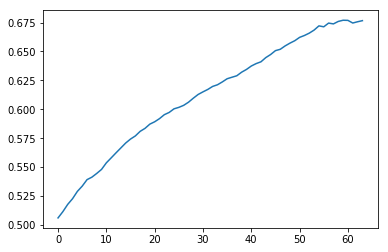

In [87]:
from matplotlib import pyplot as plt
auc = sbpr2.auc_scores
x = range(len(auc))
plt.plot(x,auc)
plt.savefig(file_dir+'plots/SBPR2/epoch120.jpg')

In [ ]:
X_test

In [ ]:
recommendation, scores, users, ranks = bpr.recommend(X_test, N = 5)

In [ ]:
print (len(recommendation))

In [ ]:
print (len(scores))

In [ ]:
print (len(users))

In [ ]:
print (len(ranks))

In [ ]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [ ]:
df_test = pd.DataFrame({'user': flatten(users), 'item': flatten(recommendation), 'score': flatten(scores), 'rank': flatten(ranks)})


In [ ]:
df_test['item'] = df_test['item'].astype(int)

In [ ]:
df_test.head()

In [ ]:
test_data = pd.DataFrame(columns = ['user_id', 'item_id', 'rating'])


In [ ]:
X_test_np = X_test.toarray()

In [ ]:
users = [i+1 for i in range(X_test_np.shape[0])]

In [ ]:
items = [i+1 for i in range(X_test_np.shape[1])]

In [ ]:
print (len(users), len(items))

In [ ]:
f = open('test_data.txt', 'w+')
for user in users:
    for item in items:
        line = str(user) + ' ' + str(item) + ' ' + str(X_test_np[user-1][item-1]) + '\n'
f.close()

In [ ]:
test_data['rating'] = test_ratings
test_data['user'] = users
test_data['item'] = items

In [ ]:
test_data.head()

In [ ]:
len(df_test['item'])

In [ ]:
len(test_data['rating'])

In [ ]:
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, item_knn as knn
from lenskit import topn

In [ ]:
df.columns = ['user', 'item', 'rating']
df_test.columns = ['user', 'item', 'score', 'rank']
df_test['Algorithm'] = ['BPR']*len(df_test['item'])

In [ ]:
test_data.head()

In [ ]:
df_test.head()

In [ ]:
df.head()

In [ ]:
df['rating'] = np.array(df['rating']).astype(float)

In [ ]:
ndcg = topn.ndcg(df_test, df)

In [ ]:
ndcg

In [ ]:
recall_at_5 = topn.recall(df_test, test_data)

In [ ]:
recall_at_5

In [ ]:
precision_at_5 = topn.precision(df_test, test_data)
precision_at_5

In [ ]:
test_data['item']

In [ ]:
cold_start = X_test.groupby('user').filter(lambda x : len(x) == 5)